# Datos del codigo:
* Estudiante: Juan Jose Valverde Campos
* Carnet: B47200
* Laboratorio 4 - CNN
* Profesor: Pablo Sauma Chacón

# Importación de Librerías

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch as pt 
# from torch.utils.data import dataset as Dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Se obtienen los datos con los cuales se va a trabajar

In [3]:
# Custom subdirectory to find images
DIRECTORY = "images"
def load_data():
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    names = [n.decode('utf-8') for n in unpickle(DIRECTORY+"/batches.meta")[b'label_names']]
    x_train = None
    y_train = []
    for i in range(1,6):
        data = unpickle(DIRECTORY+"/data_batch_"+str(i))
        if i>1:
            x_train = np.append(x_train, data[b'data'], axis=0)
        else:
            x_train = data[b'data']
        y_train += data[b'labels']
    data = unpickle(DIRECTORY+"/test_batch")
    x_test = data[b'data']
    y_test = data[b'labels']
    return names,x_train,y_train,x_test,y_test

names,x_train,y_train,x_test,y_test = load_data()

# Se obtiene la visualización de imágenes

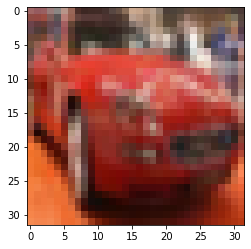

automobile


In [4]:
def plot_tensor(tensor, perm=None):
    if perm==None: perm = (1,2,0)
    plt.figure()
    plt.imshow(tensor.permute(perm).numpy().astype(np.uint8))
    plt.show()
images = pt.Tensor(x_train)
images = images.resize_(50000,3,32,32)
plot_tensor(images[5])
print(names[y_train[5]])


# Se crea la clase que va a ser llamada para entrenarse

In [5]:
# Se crea una clase que hereda de torch.nn.Module
# En el constructor se debe llamar al constructor padre  y crear sus capas
# Y se debe crear su método forward que ejecuta el paso de los datos por las neuronas


class SurvivorClassifier(pt.nn.Module):
	# def __init__(self, struct, activations,type):
	def __init__(self):
		super().__init__()
		# self.fc = []
		# self.act = []

		# self.fc1 = pt.nn.Linear(9, 5)
		# self.act1 = pt.nn.ReLU()
		# self.fc2 = pt.nn.Linear(5, 1)
		# self.act2 = pt.nn.Sigmoid()
		self.fc1 = pt.nn.Conv2d(3, 5, (3,3))
		self.act1 = pt.nn.ReLU()
		self.pool1 = pt.nn.MaxPool2d(2)

		self.fc2 = pt.nn.Conv2d(5, 3, (3,3))
		self.act2 = pt.nn.ReLU()
		self.pool2 = pt.nn.MaxPool2d(2)

		self.fc3 = pt.nn.Linear(108, 10)
		self.act3 = pt.nn.Sigmoid()





	def forward(self, x):
		h1 = self.pool1(self.act1(self.fc1(x)))
		h2 = self.pool2(self.act2(self.fc2(h1)))
		h3 = self.fc3(h2.view(h2.size(0), -1) )# Repasar que se hizo .... (Tiene una entrada enorme....)
		return self.act3( h3 )
		# h = self.act1( self.fc1(x) )
		# out = self.act2( self.fc2(h) )
		# return out


# Se convierte los datos en tensores y se hace los batch de entrenamiento

In [6]:
names,x_train,y_train,x_test,y_test = load_data()
x_train = pt.Tensor(x_train)
y_train = pt.Tensor(y_train)
x_test = pt.Tensor(x_test)
y_test = pt.Tensor(y_test)
x_train = x_train.resize_(50000,3,32,32)
x_test = x_test.resize_(10000,3,32,32)

In [7]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
# traindata = MyDataset(x_train, y_train)
traindata = MyDataset(x_train, y_train)
testdata = MyDataset(x_test, y_test)
train_dataloader = DataLoader(traindata, batch_size=5000, shuffle=True)
test_dataloader = DataLoader(testdata, shuffle=True)

Se instancia el modelo y sus parametros

In [20]:
# model = SurvivorClassifier()	# Crea el modelo
# loss_fn = pt.nn.MSELoss()		# Función de error a utilizar
# optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador


# loss_train = []
# loss_test = []

# for i in range(100):
# 	train_features, train_labels = next(iter(train_dataloader))
# 	optimizer.zero_grad()			# Coloca los Δw en 0
# 	y_pred = model( train_features) # Predice los valores del conjunto de entrenamiento
# 	loss = loss_fn(y_pred.max(1).values, train_labels)	# Calcula la pérdida
# 	loss.backward()					# Calcula el backprogration (Δw) y acumula el error
# 	optimizer.step()				# Aplica los Δw acumulados y avanza un paso la iter. 
# 	with pt.no_grad():			# Apaga el cálculo de gradientes
# 		loss2 = loss_fn( model(x_test).max(1).values, y_test)
# 	loss_train.append(loss.item())
# 	loss_test.append(loss2.item())
# 	if(i%10 == 0):
# 		print(i)
# plt.plot(loss_train)
# plt.plot(loss_test)
# plt.show()

In [13]:
model = SurvivorClassifier()	# Crea el modelo
loss_fn = pt.nn.CrossEntropyLoss()		# Función de error a utilizar torch.
optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.long())
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if i % 1000 == 999:
        #     last_loss = running_loss / 1000 # loss per batch
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            # print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            # tb_writer('Loss/train', last_loss, tb_x)
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss
def information(voutputs,y_test):
    answer = pt.argmax(voutputs, dim=1)
    correct = 0
    for i in range(y_test.size().numel()):
        if answer[i]==y_test[i]:
            correct +=1
    return correct / y_test.size().numel()

In [11]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
tensorBoard = False

EPOCHS = 5


def completeTrain(epoch_number,best_vloss):
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer)
        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        
        voutputs = model(x_test)
        vloss = loss_fn(voutputs, y_test.long())
        running_vloss += vloss


        # for i, vdata in enumerate(test_dataloader):
        #     vinputs, vlabels = vdata
        #     voutputs = model(vinputs)
        #     vloss = loss_fn(voutputs, vlabels.long())
        #     running_vloss += vloss
        avg_vloss = running_vloss
        # avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Propotion: {}'.format(information(voutputs,y_test)))
        # # Log the running loss averaged per batch
        # # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            print("entra")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            # pt.save({
            # 'epoch': epoch,
            # 'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            # 'loss': best_vloss,
            # }, "myModel")

        epoch_number += 1
epoch_number = 0
best_vloss = 1_000_000.
# completeTrain(epoch_number,best_vloss)

In [14]:
checkpoint = pt.load("trueModel")
model = SurvivorClassifier()
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
completeTrain(epoch_number,best_vloss)

EPOCH 1:
LOSS train 1.9011454105377197 valid 1.9176634550094604
Propotion: 0.4102
entra
EPOCH 2:
LOSS train 1.9068703651428223 valid 1.9235527515411377
Propotion: 0.4024
EPOCH 3:
LOSS train 1.9062955141067506 valid 1.9213417768478394
Propotion: 0.4132
EPOCH 4:
LOSS train 1.9031761050224305 valid 1.9164155721664429
Propotion: 0.408
entra
EPOCH 5:
LOSS train 1.905645775794983 valid 1.9210764169692993
Propotion: 0.3934


In [19]:
checkpoint = pt.load("trueModel")
model = SurvivorClassifier()
model.load_state_dict(checkpoint["model_state_dict"])
model.train(False)
voutputs = model(x_test)
vloss = loss_fn(voutputs, y_test.long())
answers = pt.argmax(voutputs, dim=1)

In [92]:
import pandas as pd
import seaborn as sns
def calculate_confusion_matrix(predict, real):
    df = pd.DataFrame(index=names,columns=names).notnull().astype('uint') # df [c][f]
    for i in range(y_test.size().numel()):
        df[names[real[i].item()]] [names[predict[i].item()]]+=1
    
    return df.astype(int)
    # P =  Predict 
    # R =  Real 
    # [1 .(P=F,R=F) = ,2. (P=F,R=T)],[3. (P=T,R=F),4. (P=T,R=T)]
    # [4] [3]
    # [2] [1]
y_test = y_test.to(pt.int32)
predict = pt.argmax(voutputs, dim=1)
df = calculate_confusion_matrix(predict,y_test)

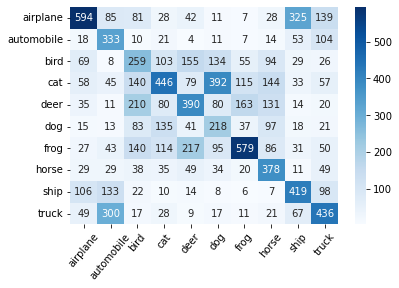

In [93]:
df
ax = sns.heatmap(df, annot=True,fmt='g', cmap='Blues')
sea = ax.set_xticklabels(ax.get_xticklabels(),rotation = 50)

In [192]:
def getAccurracy(df):
    trues = np.diagonal(df)
    totalVal = df.values.sum() 
    return trues.sum() / totalVal


def getTP(df,Class):
    return df[Class][Class]

def getTN(df,Class):
    return np.diagonal(df).sum()-df[Class][Class]

def getFP(df,Class):
    return df[Class:Class].values.sum()-df[Class][Class]

def getFN(df,Class):
    return df[Class].values.sum()-df[Class][Class]


def getConfusionClass(df,Class):
    tp = getTP(df,Class)
    tn = getTN(df,Class)
    fp = getFP(df,Class)
    fn = getFN(df,Class)
    prec = tp / (tp+fp)
    reca = tp / (tp+fn)
    return {
                "Accuracy": getAccurracy(df),
                "Precision": prec,
                "Recall":reca,
                "F1": 2 * prec*reca /(prec+reca),
                "Sensitivity": reca,
                "Specificity":tn/(tn+fp)
            }
    
print(getConfusionClass(df,"cat"))

{'Accuracy': 0.4052, 'Precision': 0.29555997349237906, 'Recall': 0.446, 'F1': 0.35552012754085294, 'Sensitivity': 0.446, 'Specificity': 0.772328121653459}
